In [744]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import warnings


warnings.filterwarnings('ignore')
%matplotlib inline

# Q3. The historical daily closing prices of Google, Amazon, Yahoo and Apple are available online. Select a stock ticker of your choice and download its historical daily closing price for 1 year. 
P.S.: *Professor, I need to address an oversight in my assignment. I inadvertently selected Ubisoft stock data instead of choosing from the four designated options. I only realized this after completing all required analyses. I want to assure you that I can easily apply the same analytical procedures to any of the approved stocks if needed.* 

Data overview:
             Open   High    Low  Close   Volume
Date                                           
2024-03-12  19.35  19.86  19.25  19.60   565034
2024-03-13  19.60  20.11  19.33  19.83   585369
2024-03-14  19.94  20.11  18.76  19.17   895154
2024-03-15  19.11  19.25  18.83  18.97  2461966
2024-03-18  19.16  19.63  18.99  18.99   439147

Data shape: (255, 5)

Data information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255 entries, 2024-03-12 to 2025-03-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    255 non-null    float64
 1   High    255 non-null    float64
 2   Low     255 non-null    float64
 3   Close   255 non-null    float64
 4   Volume  255 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 12.0 KB
None

Statistical summary:
             Open        High         Low       Close        Volume
count  255.000000  255.000000  255.000000  255.000000  2.550000e+02
mean    16.1

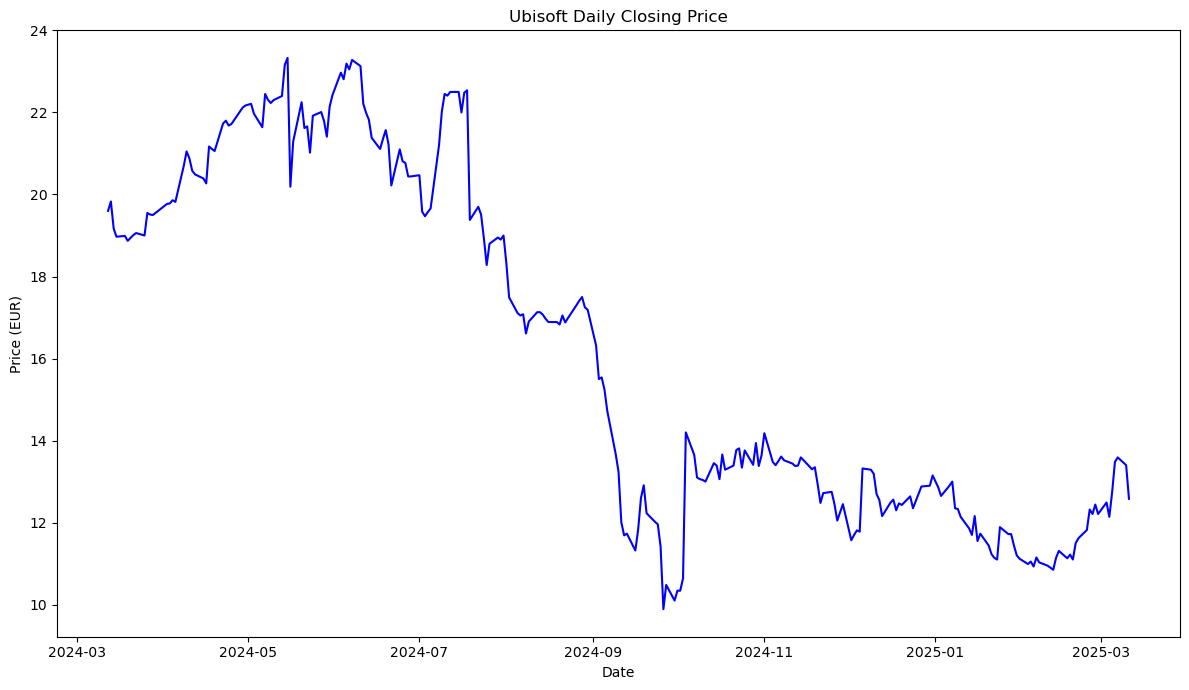

In [975]:
plt.rcParams['figure.figsize'] = (12, 7)

df = pd.read_csv('TSF_HW2_Q3_Ubisoft_data.csv', sep=';')

# Processing numeric columns to handle European number format with spaces
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(' ', '.').str.replace(',', '.')
        df[col] = pd.to_numeric(df[col])

df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%y', errors='coerce') # Converting the date column to datetime format (European format DD.MM.YY)
df.set_index('Date', inplace=True)
df = df.sort_index()

print("Data overview:")
print(df.head())
print("\nData shape:", df.shape)
print("\nData information:")
print(df.info())
print("\nStatistical summary:")
print(df.describe())

# a. Plotting the daily closing price:
plt.figure()
plt.plot(df['Close'], color='blue', linewidth=1.5)
plt.title('Ubisoft Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (EUR)')
plt.tight_layout()
plt.savefig('ubisoft_closing_price.png')
plt.show()

ADF Statistic: -1.02
p-value: 0.75

Stationarity test result: Series is non-stationary


<Figure size 1100x700 with 0 Axes>

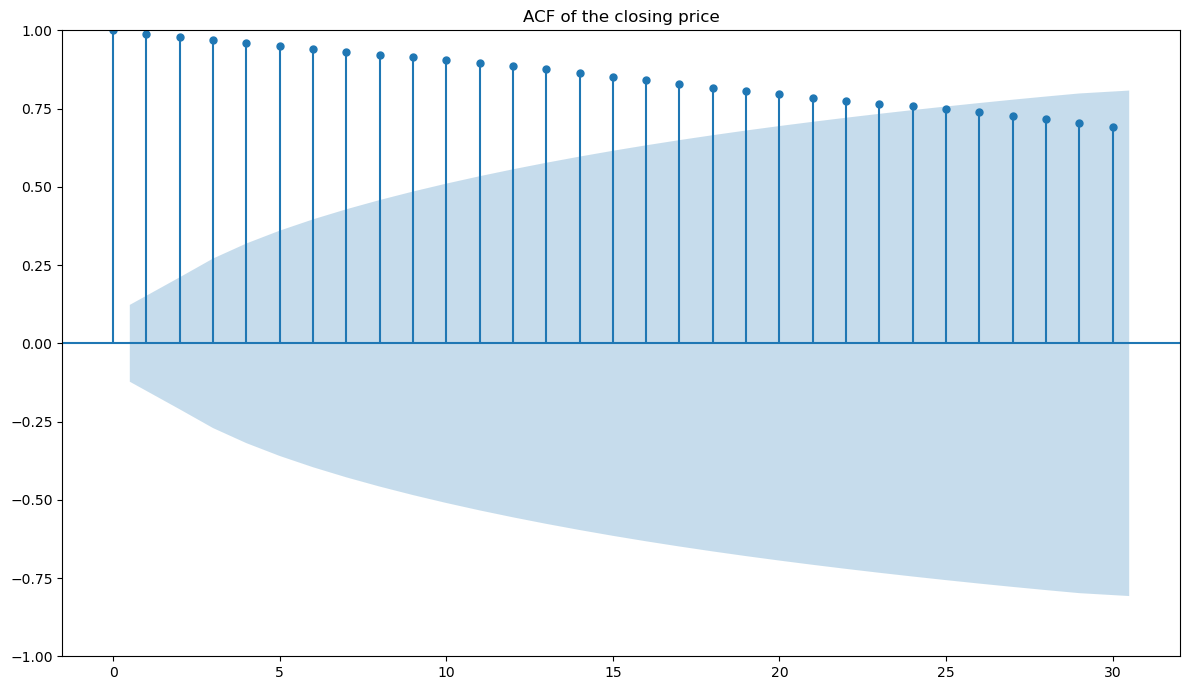

In [939]:
# b. Determine if it is a random walk or not:
# 1. ADF test
adf_result = adfuller(df['Close'])
print('ADF Statistic: {:.2f}'.format(adf_result[0]))
print('p-value: {:.2f}'.format(adf_result[1]))

is_stationary = adf_result[1] < 0.05
print(f"\nStationarity test result: Series is {'stationary' if is_stationary else 'non-stationary'}")

# 2. Visualizing the autocorrelation plot
plt.figure(figsize=(11, 7))
plot_acf(df['Close'], lags=30, alpha=0.05, title='ACF of the closing price')
plt.tight_layout()
plt.savefig('acf_with_significance.png')
plt.show()

### Since the ADF test shows that the data is non-stationary, and acf plot, confirming that fact looks like this, we cannot use Random walk here. 

>Firstly, we need to turn the data stationary:


TESTING FOR RANDOM WALK

First Differenced Series ADF Test:
ADF Statistic: -16.51
p-value: 0.00

Differenced series stationarity: Stationary


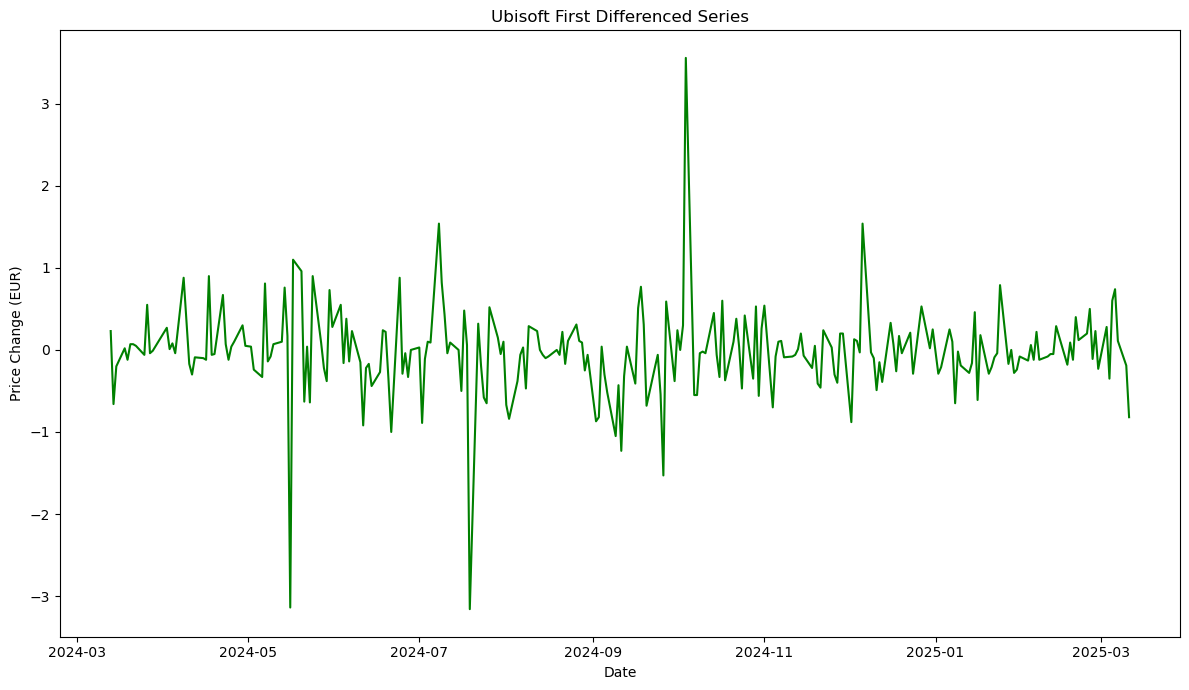

In [973]:
df['First_Diff'] = df['Close'].diff()

# Removing NaN values resulting from differencing
diff_series = df['First_Diff'].dropna()

adf_diff_result = adfuller(diff_series) # 1. Testing stationarity of differenced series with ADF
print('\nTESTING FOR RANDOM WALK')
print('\nFirst Differenced Series ADF Test:')
print('ADF Statistic: {:.2f}'.format(adf_diff_result[0]))
print('p-value: {:.2f}'.format(adf_diff_result[1]))

is_diff_stationary = adf_diff_result[1] < 0.05
print(f"\nDifferenced series stationarity: {'Stationary' if is_diff_stationary else 'Non-stationary'}")

# Plotting the differenced series
plt.figure(figsize=(12, 7))
plt.plot(df['First_Diff'], color='green', linewidth=1.5)
plt.title('Ubisoft First Differenced Series')
plt.xlabel('Date')
plt.ylabel('Price Change (EUR)')
plt.tight_layout()
plt.savefig('first_differenced_series.png')
plt.show()

<Figure size 1200x700 with 0 Axes>

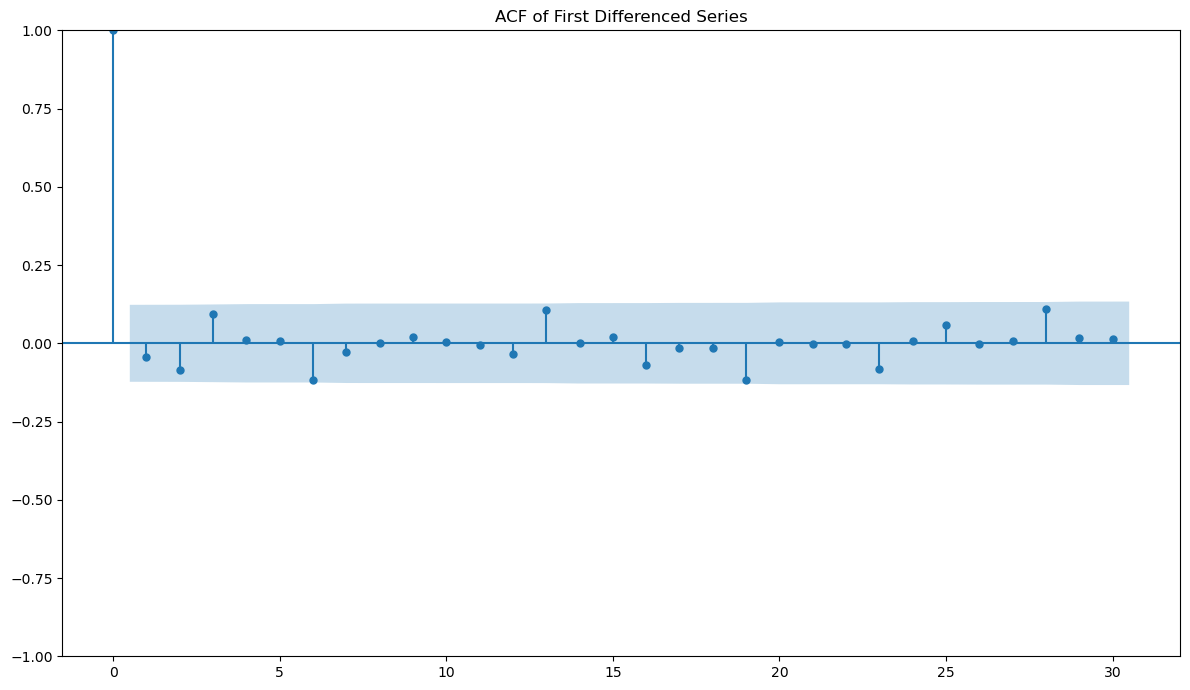

In [965]:
# 2. Autocorrelation of differenced series
plt.figure(figsize=(12, 7))
plot_acf(diff_series, lags=30, alpha=0.05, title='ACF of First Differenced Series')
plt.tight_layout()
plt.savefig('differenced_acf.png')
plt.show()

### c) As we see from the plot, the all the lags fall within the signifficance bands (the blue region) after a single differencing, therefore we have randomness in the past, which means that Random Walk is applicable now.

---

In [941]:
# d. Split into training and test sets (keeping last 5 days as test)
train = df.iloc[:-5]
test = df.iloc[-5:]

print("\nTraining set shape:", train.shape)
print("Test set shape:", test.shape)
print("\nTest set data:")
print(test[['Close']])


Training set shape: (250, 5)
Test set shape: (5, 5)

Test set data:
            Close
Date             
2025-03-05  12.74
2025-03-06  13.48
2025-03-07  13.59
2025-03-10  13.40
2025-03-11  12.58


In [943]:
# e. Forecast using naive methods and measure MSE
# Method 1: Naive forecast (last value)
def naive_forecast(train, test):
    forecast = [train['Close'].iloc[-1]] * len(test)
    return pd.Series(forecast, index=test.index)

# Method 2: Simple average
def average_forecast(train, test):
    forecast = [train['Close'].mean()] * len(test)
    return pd.Series(forecast, index=test.index)

# Method 3: Drift method (last value plus average change)
def drift_forecast(train, test):
    h = np.arange(1, len(test) + 1)
    last_value = train['Close'].iloc[-1]
    drift = (train['Close'].iloc[-1] - train['Close'].iloc[0]) / (len(train) - 1)
    forecast = [last_value + drift * i for i in h]
    return pd.Series(forecast, index=test.index)

# Method 4: Simple Exponential Smoothing
def ses_forecast(train, test):
    model = sm.tsa.SimpleExpSmoothing(train['Close']).fit(smoothing_level=0.85)
    forecast = model.forecast(len(test))
    return forecast

# Method 5: Holt's Linear Trend Method
def holt_forecast(train, test):
    model = sm.tsa.Holt(train['Close']).fit(smoothing_level=0.8, smoothing_trend=0.82)
    forecast = model.forecast(len(test))
    return forecast

In [945]:
forecasts = {'Naive': naive_forecast(train, test),
            'Average': average_forecast(train, test),
            'Drift': drift_forecast(train, test),
            'Simple Exponential Smoothing': ses_forecast(train, test),
            'Holt\'s Linear': holt_forecast(train, test)}

In [947]:
# Calculate MSE for each method
mse_results = {}
for name, forecast in forecasts.items():
    mse = mean_squared_error(test['Close'], forecast)
    mse_results[name] = mse
    print(f"MSE for {name} method: {mse:.4f}")

# The best method
best_method = min(mse_results, key=mse_results.get)
print(f"\nThe best forecasting method is: {best_method} with MSE of {mse_results[best_method]:.4f}")

MSE for Naive method: 1.2079
MSE for Average method: 9.7369
MSE for Drift method: 1.3959
MSE for Simple Exponential Smoothing method: 1.1146
MSE for Holt's Linear method: 2.1539

The best forecasting method is: Simple Exponential Smoothing with MSE of 1.1146


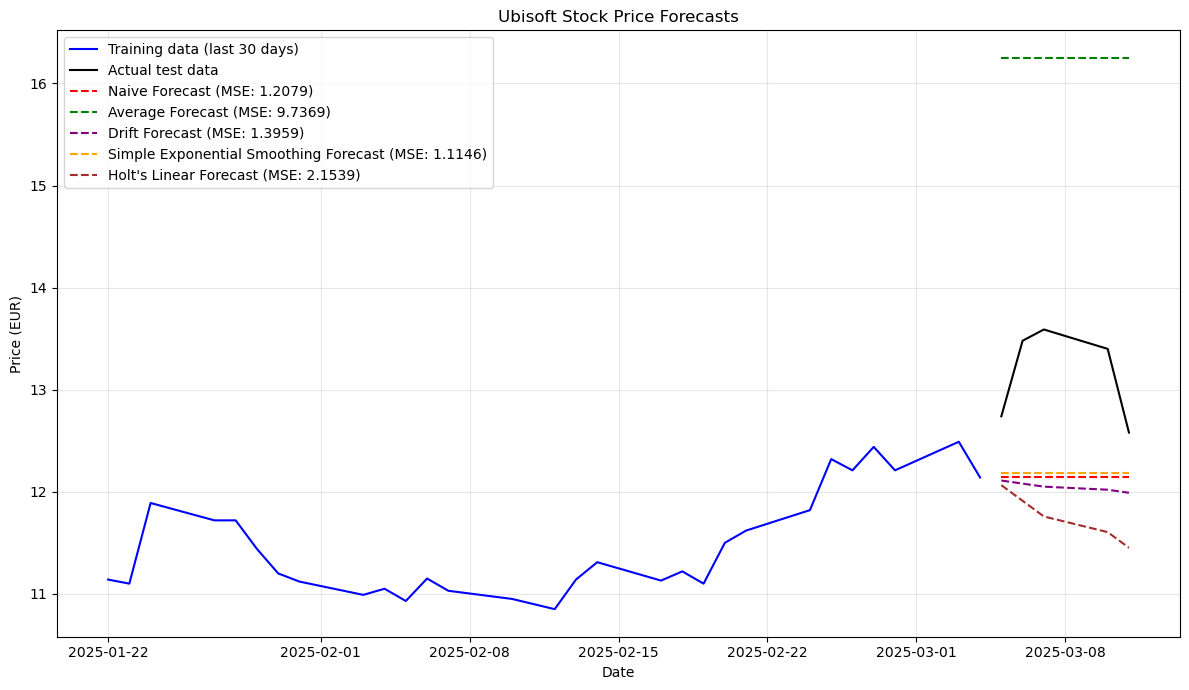

In [951]:
# f. Plot forecasts
plt.figure(figsize=(12, 7))
plt.plot(train.index[-30:], train['Close'].iloc[-30:], label='Training data (last 30 days)', color='blue')
plt.plot(test.index, test['Close'], label='Actual test data', color='black', linestyle='-')

colors = ['red', 'green', 'purple', 'orange', 'brown']
for (name, forecast), color in zip(forecasts.items(), colors):
    plt.plot(test.index, forecast, label=f'{name} Forecast (MSE: {mse_results[name]:.4f})', color=color, linestyle='--')

plt.title('Ubisoft Stock Price Forecasts')
plt.xlabel('Date')
plt.ylabel('Price (EUR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('forecast_comparison.png')
plt.show()

In [983]:
# g. Forecast the next time-step over the test set and measure MSE
def rolling_forecast(method, train_data, test_data):
    forecasts = []
    rolling_train = train_data.copy()
    
    for i in range(len(test_data)):
        if method == 'Naive':
            forecast = rolling_train['Close'].iloc[-1]
        elif method == 'Average':
            forecast = rolling_train['Close'].mean()
        elif method == 'Drift':
            drift = (rolling_train['Close'].iloc[-1] - rolling_train['Close'].iloc[0]) / (len(rolling_train) - 1)
            forecast = rolling_train['Close'].iloc[-1] + drift
        elif method == 'Simple Exponential Smoothing':
            model = sm.tsa.SimpleExpSmoothing(rolling_train['Close']).fit(smoothing_level=0.8)
            forecast_result = model.forecast(1)
            forecast = forecast_result.values[0] if hasattr(forecast_result, 'values') else forecast_result[0] # Extracting the value safely 
                                                                                                                # to avoid errors
        elif method == 'Holt\'s Linear':
            model = sm.tsa.Holt(rolling_train['Close']).fit(smoothing_level=0.8, smoothing_trend=0.2)
            forecast_result = model.forecast(1) # Forecasts without indexing
            forecast = forecast_result.values[0] if hasattr(forecast_result, 'values') else forecast_result[0] # Extracting the value safely 
                                                                                                                # to avoid errors
        
        forecasts.append(forecast)
        # Adding the actual value to the rolling training set for the next iteration
        next_row = pd.DataFrame({'Close': test_data['Close'].iloc[i]}, index=[test_data.index[i]])
        rolling_train = pd.concat([rolling_train, next_row])
    
    return pd.Series(forecasts, index=test_data.index)

In [981]:
# Rolling forecast for all methods
rolling_forecasts = {}
rolling_mse_results = {}

for name in forecasts.keys():
    rolling_forecast_result = rolling_forecast(name, train, test)
    rolling_forecasts[name] = rolling_forecast_result
    rolling_mse = mean_squared_error(test['Close'], rolling_forecast_result)
    rolling_mse_results[name] = rolling_mse
    print(f"Rolling MSE for {name} method: {rolling_mse:.2f}")

# Finding the best rolling forecast method by picking the minimum mse-valued forecast method among the rest
best_rolling_method = min(rolling_mse_results, key=rolling_mse_results.get)
print(f"\nThe best rolling forecast method is: {best_rolling_method} with MSE of {rolling_mse_results[best_rolling_method]:.2f}")

# Comparing original vs rolling forecast MSEs
print("\nMSE Comparison (Original vs Rolling):")
for name in forecasts.keys():
    change = (rolling_mse_results[name] - mse_results[name]) / mse_results[name] * 100
    status = "Decreased" if rolling_mse_results[name] < mse_results[name] else "Increased"
    print(f"{name}: {mse_results[name]:.2f} → {rolling_mse_results[name]:.2f} ({status} by {abs(change):.2f}%)")

Rolling MSE for Naive method: 0.33
Rolling MSE for Average method: 9.59
Rolling MSE for Drift method: 0.33
Rolling MSE for Simple Exponential Smoothing method: 0.36
Rolling MSE for Holt's Linear method: 0.41

The best rolling forecast method is: Naive with MSE of 0.33

MSE Comparison (Original vs Rolling):
Naive: 1.21 → 0.33 (Decreased by 73.04%)
Average: 9.74 → 9.59 (Decreased by 1.54%)
Drift: 1.40 → 0.33 (Decreased by 76.16%)
Simple Exponential Smoothing: 1.11 → 0.36 (Decreased by 67.28%)
Holt's Linear: 2.15 → 0.41 (Decreased by 80.82%)


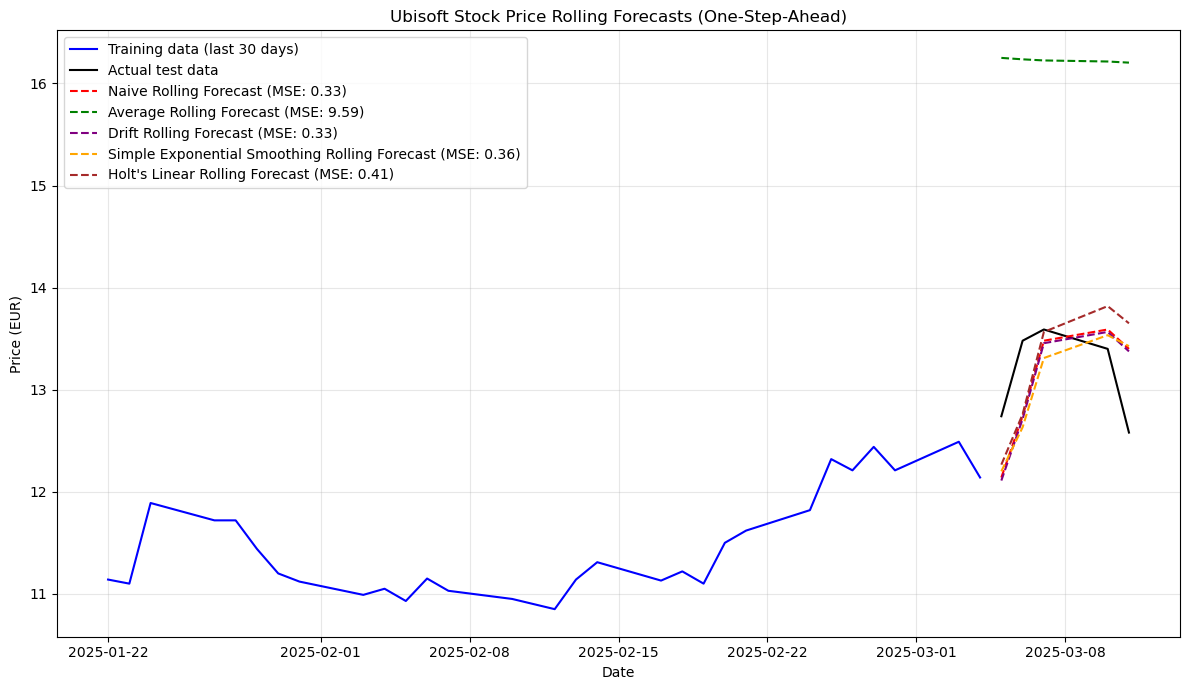

In [882]:
# h. Plot the rolling forecasts
plt.figure(figsize=(12, 7))
plt.plot(train.index[-30:], train['Close'].iloc[-30:], label='Training data (last 30 days)', color='blue')
plt.plot(test.index, test['Close'], label='Actual test data', color='black', linestyle='-')

colors = ['red', 'green', 'purple', 'orange', 'brown']
for (name, forecast), color in zip(rolling_forecasts.items(), colors):
    plt.plot(test.index, forecast, label=f'{name} Rolling Forecast (MSE: {rolling_mse_results[name]:.2f})', color=color, linestyle='--')

plt.title('Ubisoft Stock Price Rolling Forecasts (One-Step-Ahead)')
plt.xlabel('Date')
plt.ylabel('Price (EUR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rolling_forecast_comparison.png')
plt.show()

In [905]:
print("\nSUMMARY OF FINDINGS")
print("\n1. Best Forecasting Method:")
print(f"   - Fixed Forecast: {best_method} (MSE: {mse_results[best_method]:.2f})")
print(f"   - Rolling Forecast: {best_rolling_method} (MSE: {rolling_mse_results[best_rolling_method]:.2f})")

print("\n2. Rolling Forecast vs. Fixed Forecast:")
if min(rolling_mse_results.values()) < min(mse_results.values()):
    print("   - Rolling forecasts performed better than fixed forecasts.")
    print("   - This suggests that incorporating new information improves prediction accuracy.")
else:
    print("   - Fixed forecasts performed better than rolling forecasts.")
    print("   - This suggests that the additional information didn't improve prediction accuracy.")


SUMMARY OF FINDINGS

1. Best Forecasting Method:
   - Fixed Forecast: Simple Exponential Smoothing (MSE: 1.11)
   - Rolling Forecast: Naive (MSE: 0.33)

2. Rolling Forecast vs. Fixed Forecast:
   - Rolling forecasts performed better than fixed forecasts.
   - This suggests that incorporating new information improves prediction accuracy.


> # Q9: Simulate a stationary MA(2) process

In [911]:
np.random.seed(42)

ma2 = np.array([1, 0.9, 0.3]) # MA(2) process parameters
ar2 = np.array([1, 0, 0])

MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)
df_MA2 = pd.DataFrame(MA2_process, columns=['value'])

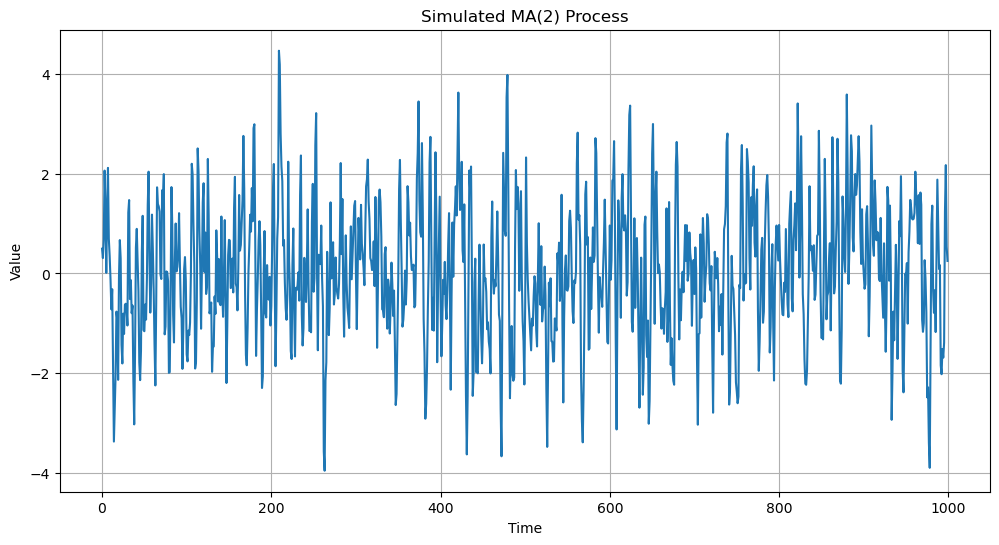

In [913]:
# Visualizing MA(2) process
plt.figure(figsize=(12, 6))
plt.plot(df_MA2['value'])
plt.title('Simulated MA(2) Process')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [915]:
# ADF test to check stationarity
result = adfuller(df_MA2['value'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')

if result[1] < 0.05:
    print("The process is stationary (reject H0)")
else:
    print("The process is non-stationary (fail to reject H0)")

ADF Statistic: -14.005444309194484
p-value: 3.7956016167136117e-26
Critical Values:
The process is stationary (reject H0)


<Figure size 1200x600 with 0 Axes>

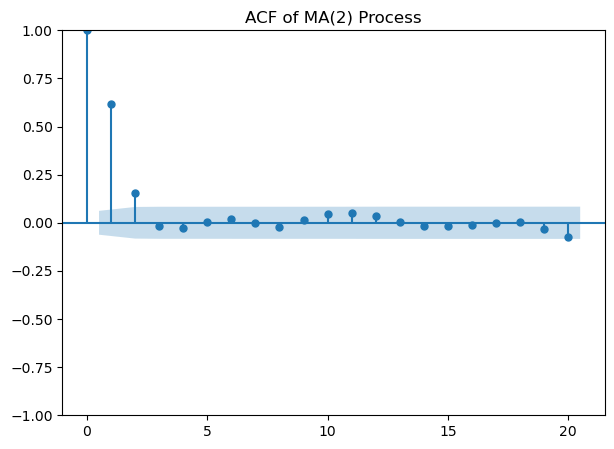

In [917]:
# ACF to check for significant lags
plt.figure(figsize=(12, 6))
plot_acf(df_MA2['value'], lags=20)
plt.title('ACF of MA(2) Process')
plt.show()

In [919]:
train_MA2 = df_MA2.iloc[:800].copy()
test_MA2 = df_MA2.iloc[800:].copy()

In [921]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i]['value'].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean
        
    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i]['value'].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA2 = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA2.extend(oos_pred)
            
        return pred_MA2

In [923]:
# Generating forecasts using the rolling_forecast function
TRAIN_LEN = len(train_MA2)
HORIZON = len(test_MA2)
WINDOW = 2

pred_mean = rolling_forecast(df_MA2, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_MA2, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA2 = rolling_forecast(df_MA2, TRAIN_LEN, HORIZON, WINDOW, 'MA')

# Adding predictions to test_ma2 DataFrame
test_MA2['pred_mean'] = pred_mean
test_MA2['pred_last_value'] = pred_last_value
test_MA2['pred_MA2'] = pred_MA2

test_MA2.head() # Checking the first 5 rows of test data with predictions

,value,pred_mean,pred_last_value,pred_MA2
800,0.973560,-0.017430,0.259693,0.065366
801,0.337338,-0.017430,0.259693,0.017984
802,-0.086834,-0.015752,0.337338,-0.180397
803,-0.530580,-0.015752,0.337338,-0.116820
804,-0.821708,-0.016481,-0.530580,-0.405768


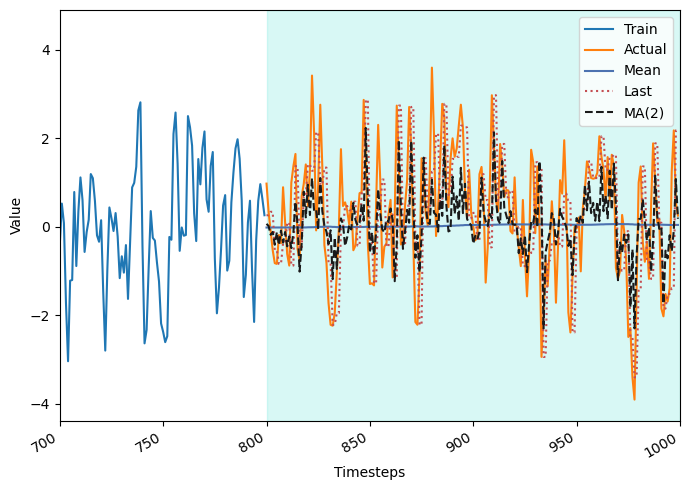

In [935]:
fig, ax = plt.subplots()
ax.plot(train_MA2['value'], label='Train')
ax.plot(test_MA2['value'], label='Actual')
ax.plot(test_MA2['pred_mean'], 'b-', label='Mean')
ax.plot(test_MA2['pred_last_value'], 'r:', label='Last')
ax.plot(test_MA2['pred_MA2'], 'k--', label='MA(2)')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.legend(loc='best')
ax.axvspan(800, 1000, color='turquoise', alpha=0.2)
plt.xlim(700, 1000)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [585]:
# MSE for each model (mean vs last value vs MA(2)):
mse_mean = mean_squared_error(test_MA2['value'], test_MA2['pred_mean'])
mse_last = mean_squared_error(test_MA2['value'], test_MA2['pred_last_value'])
mse_MA2 = mean_squared_error(test_MA2['value'], test_MA2['pred_MA2'])

print(f'Mean MSE: {mse_mean}')
print(f'Last Value MSE: {mse_last}')
print(f'MA(2) MSE: {mse_MA2}')

Mean MSE: 1.8635013982365882
Last Value MSE: 1.9882016885279188
MA(2) MSE: 1.2323542190575656


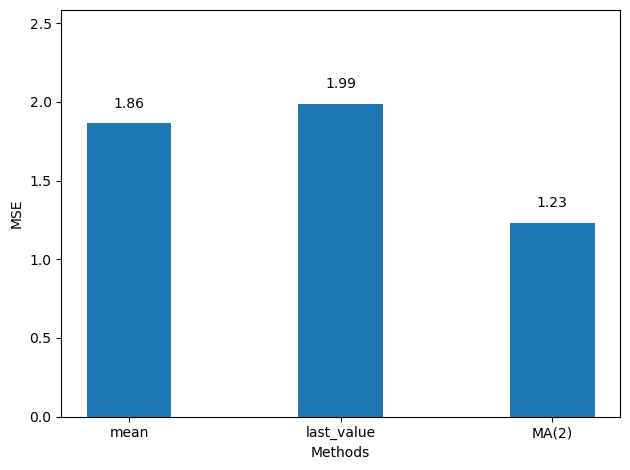

In [587]:
fig, ax = plt.subplots()
x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA2]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, max(y) * 1.3)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.1, s=str(round(value, 2)), ha='center')
    
plt.tight_layout()
plt.show()

> # Q10: Simulate a stationary AR(2) process

In [589]:
np.random.seed(42)

ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)
df_AR2 = pd.DataFrame(AR2_process, columns=['value'])

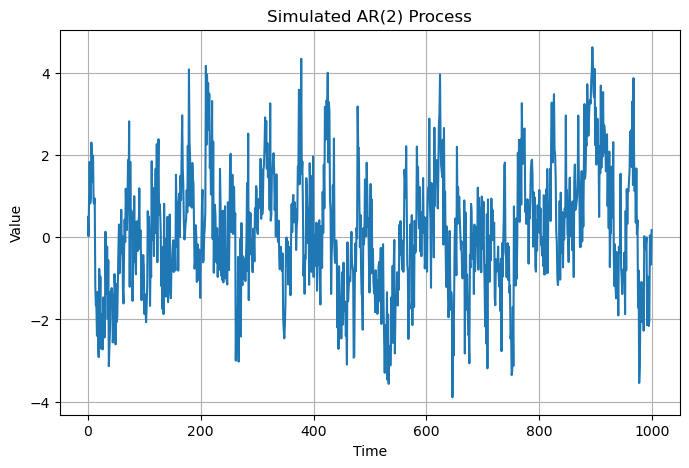

In [591]:
# Visualizing the simulated AR(2) process
plt.figure(figsize=(8, 5))
plt.plot(AR2_process)
plt.title('Simulated AR(2) Process')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [593]:
result = adfuller(AR2_process) # ADF test to check stationarity
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("We reject H0, therefore the process is stationary")
else:
    print("The process is non-stationary (fail to reject H0)")

ADF Statistic: -7.566606021416887
p-value: 2.9145161293766256e-11
We reject H0, therefore the process is stationary


<Figure size 1200x1000 with 0 Axes>

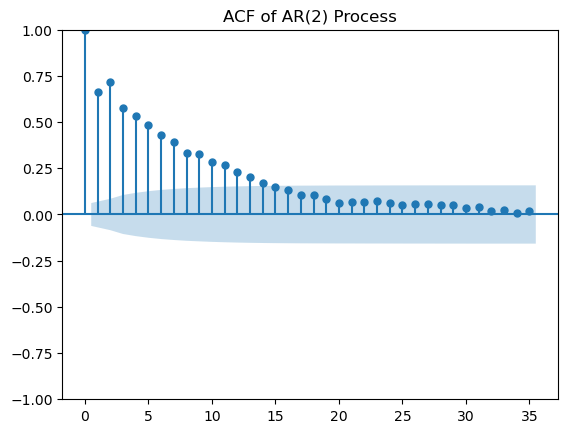

In [595]:
# ACF to see what it looks like
plt.figure(figsize=(12, 10))
plot_acf(AR2_process, lags=35)
plt.title('ACF of AR(2) Process')
plt.show()

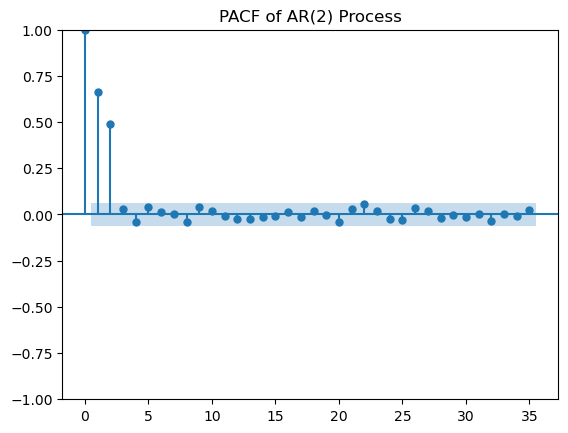

In [597]:
plot_pacf(AR2_process, lags=35);
plt.title('PACF of AR(2) Process')
plt.show()

In [599]:
train_AR = df_AR2.iloc[:800].copy()
test_AR = df_AR2.iloc[800:].copy()

In [601]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            if isinstance(df, pd.Series):
                mean = np.mean(df[:i])
            else:
                mean = np.mean(df[:i]['value'])
            
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean
    
    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            if isinstance(df, pd.Series):
                last_value = df[:i].iloc[-1]
            else:
                last_value = df[:i]['value'].iloc[-1]
                
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
    
        return pred_AR

In [603]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_AR2, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_AR2, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR2 = rolling_forecast(df_AR2, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test_AR['pred_mean'] = pred_mean
test_AR['pred_last_value'] = pred_last_value
test_AR['pred_AR2'] = pred_AR2

test_AR.head()

,value,pred_mean,pred_last_value,pred_AR2
800,1.153388,-0.049737,0.461912,0.208203
801,0.095529,-0.049737,0.461912,0.289199
802,0.704340,-0.048056,0.095529,0.586307
803,-0.182079,-0.048056,0.095529,0.233598
804,-0.142412,-0.047287,-0.182079,0.281393


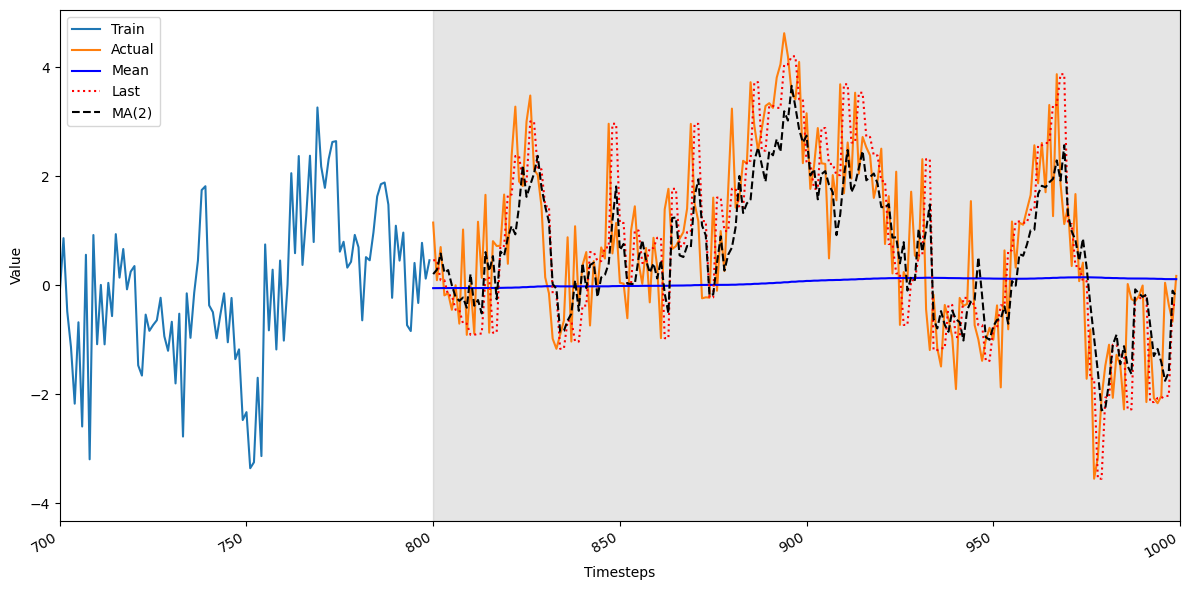

In [605]:
# Plot forecasts vs actual values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_AR['value'], label='Train')
ax.plot(test_AR['value'], label='Actual')
ax.plot(test_AR['pred_mean'], 'b-', label='Mean')
ax.plot(test_AR['pred_last_value'], 'r:', label='Last')
ax.plot(test_AR['pred_AR2'], 'k--', label='MA(2)')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.legend(loc='best')
ax.axvspan(800, 1000, color='#808080', alpha=0.2)
plt.xlim(700, 1000)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [607]:
mse_mean = mean_squared_error(test_AR['value'], test_AR['pred_mean'])
mse_last = mean_squared_error(test_AR['value'], test_AR['pred_last_value'])
mse_AR2 = mean_squared_error(test_AR['value'], test_AR['pred_AR2'])
print(f'Mean MSE: {mse_mean}')
print(f'Last Value MSE: {mse_last}')
print(f'AR(2) MSE: {mse_AR2}')

Mean MSE: 3.088201680821445
Last Value MSE: 1.211151905186967
AR(2) MSE: 0.9692635185934552


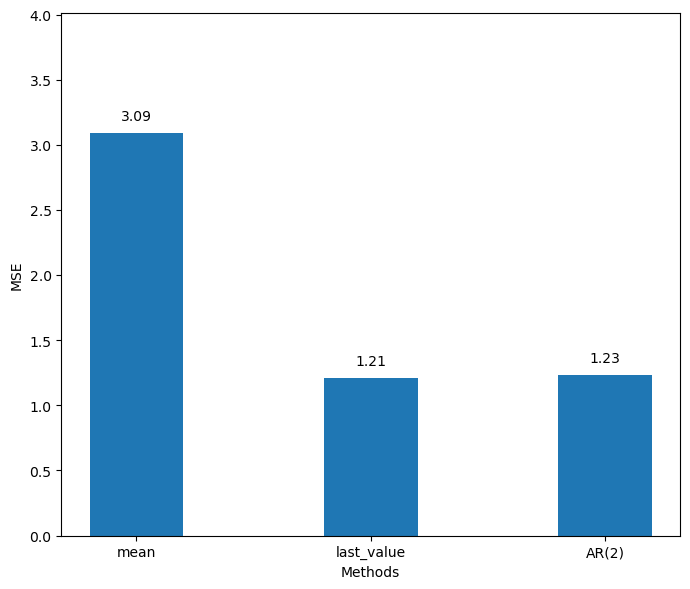

In [609]:
fig, ax = plt.subplots(figsize=(7, 6))
x = ['mean', 'last_value', 'AR(2)']
y = [mse_mean, mse_last, mse_MA2]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, max(y) * 1.3)  # Making the visualization more alligned and visible

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.1, s=str(round(value, 2)), ha='center')
    
plt.tight_layout()
plt.show()